In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons
!pip install pyyaml h5py
!pip install toolz scikit-allel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.2 MB 5.3 MB/s 


In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.9.2


## Setup

In [ ]:
import os
# os.environ["MODIN_CPUS"] = "8"
# from distributed import Client
# client = Client()
import numpy as np
import math
import re
import itertools
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_addons as tfa
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.applications import efficientnet as efn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.constraints import Constraint
# import allel
from scipy.spatial.distance import squareform
%matplotlib inline   
from toolz import interleave
from tqdm import tqdm
import allel
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import KFold,StratifiedKFold

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.2


## Hardware Config

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = strategy.num_replicas_in_sync
# Number of computing cores, is 8 for a TPU V3-8
print(f'N_REPLICAS: {N_REPLICAS}')

Running on TPU  grpc://10.15.158.98:8470


N_REPLICAS: 8


## Prepare the data

In [ ]:
root_dir = '[path]/'
new_data_header = ""
# get header
with open(root_dir + "DELL.chr22.genotypes.for.modeling.vcf", 'r') as f_in:
    # skip info
    for line_num in range(70):
        f_in.readline()

    new_data_header = f_in.readline()
# load data

# load genotype
genotypes = pd.read_csv(root_dir + "DELL.chr22.genotypes.for.modeling.vcf", comment='#', sep='\t', names=new_data_header.strip().split('\t'), header=1, index_col='Sample_id', dtype={'Sample_id':str}).iloc[:, :-1]
headers = genotypes.columns[:]
genotypes

,1,2,3,4,7,8,10,13,15,16,...,834,835,836,837,838,839,840,842,843,846
Sample_id,,,,,,,,,,,,,,,,,,,,,
HG00097,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00099,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00100,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00101,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00102,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21137,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21141,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21142,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,...,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [ ]:
ped_file = '[path]/integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(ped_file, sep='\t', index_col='Individual ID')

In [ ]:
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments
Individual ID,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0


In [ ]:
Y_train = pedigree.loc[genotypes.index]['Population']
Y_train.shape

(2503,)

In [ ]:
X = genotypes[genotypes.index.isin(Y_train.index)]
X.shape

(2503, 572)

In [ ]:
X = X.replace({
    '0|0': 0,
    '0|1': 1,
    '1|0': 2,
    '1|1': 3
})
X.shape

(2503, 572)

## LD

In [ ]:
r = allel.rogers_huff_r(X.T)
LD = squareform(r ** 2)
LD.shape

(572, 572)

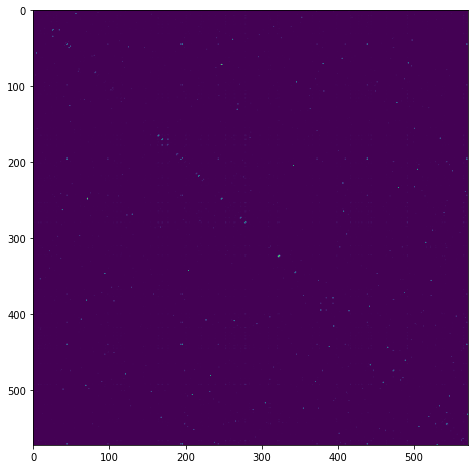

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(LD)

(array([421.,  44.,  29.,  31.,  47.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 5 Patch objects>)

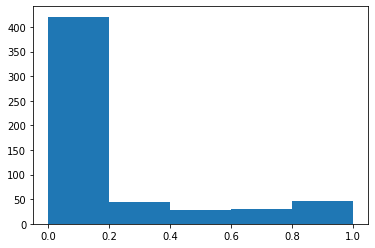

In [ ]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.hist(np.amax(LD, axis=1), bins=bins)

In [ ]:
LD_max_freqs = np.amax(LD, axis=1)
bin_labels = np.digitize(LD_max_freqs, bins=bins, right=True)
bin_general_labels, bin_counts = np.unique(bin_labels, return_counts=True)
bin_general_labels, bin_counts

(array([1, 2, 3, 4, 5]), array([421,  44,  29,  31,  47]))

In [ ]:
# hyperparameters
feature_size = X.shape[1]
inChannel = 3
learning_rate = 0.01
weight_decay = 0.00001
embed_dim = 64  # Embedding size for each token
num_heads = 8 # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
regularization_coef_l1 = 1e-5
batch_size = 20
dropout_rate = 0.25

## Convert to tensorflow dataset

In [ ]:
@tf.function()
def add_attention_mask(X_sample, y_sample):
  depth = 3
  mask_size = tf.cast(X_sample.shape[0]*0.5, dtype=tf.int64)
  mask_idx = tf.reshape(tf.random.shuffle(tf.range(X_sample.shape[0]))[:mask_size], (-1, 1))
  updates = tf.math.add(tf.ones(shape=(mask_idx.shape[0]), dtype=tf.int64), 1)
  X_masked = tf.tensor_scatter_nd_update(X_sample, mask_idx, updates)
  return tf.one_hot(X_masked, depth), tf.one_hot(y_sample, depth-1)

In [ ]:
def map_values_1(x):
  return 0 if (x == 0 or x == 1) else 1

def map_values_2(x):
  return 0 if (x == 0 or x == 2) else 1

def get_dataset(x, chunk_start, chunk_end, start_offset, end_offset, batch_size, training=True):
  AUTO = tf.data.AUTOTUNE

  _x = np.empty((x.shape[0] * 2, chunk_end-chunk_start), dtype=x.dtype)

  map_values_1_vec = np.vectorize(map_values_1)
  map_values_2_vec = np.vectorize(map_values_2)

  _x[0::2] = map_values_1_vec(x[:, chunk_start:chunk_end])
  _x[1::2] = map_values_2_vec(x[:, chunk_start:chunk_end])
  new_chunk_end = _x.shape[1]

  dataset = tf.data.Dataset.from_tensor_slices((_x,
                                                _x[:, start_offset:new_chunk_end-end_offset]))
  
  if training:
    dataset = dataset.shuffle(_x.shape[0], reshuffle_each_iteration=True)
    dataset = dataset.repeat()
  
  # Add Attention Mask
  dataset = dataset.map(add_attention_mask, num_parallel_calls=AUTO, deterministic=False)

  # Prefetech to not map the whole dataset
  dataset = dataset.prefetch(AUTO)

  dataset = dataset.batch(batch_size, drop_remainder=True, num_parallel_calls=AUTO)

  return dataset

## Model

In [ ]:
def getHLAModel(filter_sizes1=1024, filter_sizes2=512, kernel_size=512):
  inputt = layers.Input(shape=(feature_size, inChannel))
  # x = NewGenoEmbeddings(filter_sizes[0])(inputt)
  x = layers.Conv1D(filter_sizes1, kernel_size=kernel_size, padding="SAME")(inputt)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.MaxPool1D(2)(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Conv1D(filter_sizes2, kernel_size=kernel_size//2, padding="SAME")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.MaxPool1D(2)(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(8, activation=tf.nn.softmax)(x)
  x = layers.Reshape((feature_size, inChannel-1))(x)
  model = tf.keras.models.Model(inputt, x)
  return model

In [ ]:
model = getHLAModel()
model.build((1, feature_size, inChannel))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 572, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 572, 1024)         1573888   
                                                                 
 batch_normalization (BatchN  (None, 572, 1024)        4096      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 572, 1024)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 286, 1024)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 286, 1024)         0     

In [ ]:
def create_model():
  model =  getHLAModel()
  optimizer = tfa.optimizers.LAMB(learning_rate=learning_rate)
  model.compile(optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=tf.keras.metrics.CategoricalAccuracy())
  return model

In [ ]:
METRIC = "val_categorical_accuracy"

def create_callbacks(kfold=0, metric = METRIC):

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='auto',
        factor=0.2,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='auto',
        patience= 10, 
        verbose=1,
        restore_best_weights=True
    )
    
    callbacks = [
                 reducelr,
                 earlystop]         
    
    return callbacks

In [ ]:
np.unique(Y_train.values)

array(['ACB', 'ASW', 'BEB', 'CDX', 'CEU', 'CHB', 'CHS', 'CLM', 'ESN',
       'FIN', 'GBR', 'GIH', 'GWD', 'IBS', 'ITU', 'JPT', 'KHV', 'LWK',
       'MSL', 'MXL', 'PEL', 'PJL', 'PUR', 'STU', 'TSI', 'YRI'],
      dtype=object)

## Training

In [ ]:
# A TPU V3-8 has 8 computing cores, the global batch size will be 1/16 x 8 = 8/128
BATCH_SIZE_BASE = 2
# Training configuration
BATCH_SIZE = BATCH_SIZE_BASE * N_REPLICAS if TPU else 5
BATCH_SIZE

16

In [ ]:
# With constraint
missing_perc = 0.1
N_SPLITS=3
NUM_EPOCHS = 1000
accuracies = []
results = None
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
_y = Y_train.to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
    
  print(f"Training using fold {fold}")
  
  x_train, y_train, test_dataset, test_indices = _x[train_index], _y[train_index], (_x[test_index], _y[test_index]),Y_train.index[test_index]
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10,
                                      random_state=fold,
                                      shuffle=True)
  
  steps_per_epoch = 2*x_train.shape[0]//BATCH_SIZE
  validation_steps = 2*x_valid.shape[0]//BATCH_SIZE
  train_dataset = get_dataset(x_train, 0, feature_size, 0, 0, BATCH_SIZE)
  valid_dataset = get_dataset(x_valid, 0, feature_size, 0, 0, BATCH_SIZE, training=False)

  K.clear_session()
  callbacks = create_callbacks()
  with strategy.scope():
    model = create_model()
    history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch, epochs=NUM_EPOCHS, 
            validation_data=valid_dataset,
            validation_steps=validation_steps,
            callbacks=callbacks, verbose=1)
  for missing_perc in [
                         0.05,
                         0.1,
                         0.2
                         ]:
    save_name = f"[path]/Chr.22.DELS/HLA_DEEP/preds_mixed_mr_{missing_perc}_rs_{fold}_.csv"
    avg_accuracy = []
    preds = []
    true_labels = []
    
    to_save_array = np.zeros((test_dataset[0].shape[0], test_dataset[0].shape[1]), dtype=object)
    test_X_missing = np.empty((test_dataset[0].shape[0] * 2, test_dataset[0].shape[1]), dtype=test_dataset[0].dtype)
    map_values_1_vec = np.vectorize(map_values_1)
    map_values_2_vec = np.vectorize(map_values_2)
    test_X_missing[0::2] = map_values_1_vec(test_dataset[0])
    test_X_missing[1::2] = map_values_2_vec(test_dataset[0])
    test_X_missing = to_categorical(test_X_missing, 3)
    
    for i in tqdm(range(test_dataset[0].shape[0])):
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_perc,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      test_X_missing[i*2:i*2+2, missing_index, :] = [0, 0, 1]
      # predict
      predict_onehot = model.predict(test_X_missing[i*2:i*2+2, :, :], verbose=0)
      # only care the missing position
      predict_missing_onehot = predict_onehot[0:2, missing_index, :]
      # predict label
      predict_missing = np.argmax(predict_missing_onehot, axis=2)
      predict_missing_final = np.zeros((1, predict_missing.shape[1]))
      for j in range(predict_missing.shape[1]):
        if predict_missing[:, j].tolist() == [0, 0]:
          predict_missing_final[:, j] = 0
        elif predict_missing[:, j].tolist() == [0, 1]:
          predict_missing_final[:, j] = 1
        elif predict_missing[:, j].tolist() == [1, 0]:
          predict_missing_final[:, j] = 2
        elif predict_missing[:, j].tolist() == [1, 1]:
          predict_missing_final[:, j] = 3
        else:
          predict_missing_final[:, j] = 4
      preds.extend(predict_missing_final.ravel().tolist())
      
      predict_haplotypes = np.argmax(predict_onehot, axis=2)
      for j in range(predict_onehot.shape[1]):
        if predict_haplotypes[:, j].tolist() == [0,0]:
          to_save_array[i, j] = '0|0'
        elif predict_haplotypes[:, j].tolist() == [0,1]:
          to_save_array[i, j] = '0|1'
        elif predict_haplotypes[:, j].tolist() == [1,0]:
          to_save_array[i, j] = '1|0'
        elif predict_haplotypes[:, j].tolist() == [1, 1]:
          to_save_array[i, j] = '1|1'
        else:
          to_save_array[i, j] = '.|.'
      # real label
      label_missing_onehot = test_dataset[0][i:i + 1, missing_index]
      label_missing = test_dataset[0][i:i + 1, missing_index]
      true_labels.extend(label_missing.ravel().tolist())
      # accuracy
      correct_prediction = np.equal(predict_missing_final, label_missing)
      accuracy = np.mean(correct_prediction)

      avg_accuracy.append(accuracy)

    df = pd.DataFrame(to_save_array, columns= headers[:], index = Y_train.index[test_index])
    df.to_csv(save_name)
    print('The average imputation accuracy' \
          'on test data with {} missing genotypes is {:.4f}: '
        .format(missing_perc, np.mean(avg_accuracy)))
    cnf_matrix = confusion_matrix(true_labels, preds)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    print(f"Sensitivity: {np.mean(TPR)}")
    print(f"Specificity: {np.mean(TNR)}")
    print(f"F1-score macro: {f1_score(true_labels, preds, average='macro')}")
    print(f"F1-score micro: {f1_score(true_labels, preds, average='micro')}")
    accuracies.append(np.mean(avg_accuracy))
  print(f"=====================================")
        
    

Training using fold 1
Epoch 1/1000
187/187 [==============================] - 37s 135ms/step - loss: 0.1207 - categorical_accuracy: 0.9668 - val_loss: 0.1614 - val_categorical_accuracy: 0.9750 - lr: 0.0100
Epoch 2/1000
187/187 [==============================] - 19s 99ms/step - loss: 0.0438 - categorical_accuracy: 0.9861 - val_loss: 0.0811 - val_categorical_accuracy: 0.9753 - lr: 0.0100
Epoch 3/1000
187/187 [==============================] - 18s 96ms/step - loss: 0.0399 - categorical_accuracy: 0.9872 - val_loss: 0.0432 - val_categorical_accuracy: 0.9880 - lr: 0.0100
Epoch 4/1000
187/187 [==============================] - 18s 95ms/step - loss: 0.0390 - categorical_accuracy: 0.9874 - val_loss: 0.0350 - val_categorical_accuracy: 0.9888 - lr: 0.0100
Epoch 5/1000
187/187 [==============================] - 16s 88ms/step - loss: 0.0382 - categorical_accuracy: 0.9875 - val_loss: 0.0353 - val_categorical_accuracy: 0.9884 - lr: 0.0100
Epoch 6/1000
187/187 [==============================] - 18s 95

100%|██████████| 835/835 [08:59<00:00,  1.55it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9628: 
Sensitivity: 0.4505203665085056
Specificity: 0.8451957638610973
F1-score macro: 0.46419302347708874
F1-score micro: 0.9628314798973482


100%|██████████| 835/835 [08:07<00:00,  1.71it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9626: 
Sensitivity: 0.4572970788656864
Specificity: 0.8491425004518894
F1-score macro: 0.4698702416798057
F1-score micro: 0.9625801029519907


100%|██████████| 835/835 [08:08<00:00,  1.71it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9619: 
Sensitivity: 0.4417067477481442
Specificity: 0.8406830603953073
F1-score macro: 0.4557357835468501
F1-score micro: 0.9618657421998109
Training using fold 2
Epoch 1/1000
187/187 [==============================] - 25s 113ms/step - loss: 0.0963 - categorical_accuracy: 0.9741 - val_loss: 0.1574 - val_categorical_accuracy: 0.9752 - lr: 0.0100
Epoch 2/1000
187/187 [==============================] - 18s 96ms/step - loss: 0.0437 - categorical_accuracy: 0.9861 - val_loss: 0.0940 - val_categorical_accuracy: 0.9752 - lr: 0.0100
Epoch 3/1000
187/187 [==============================] - 18s 95ms/step - loss: 0.0403 - categorical_accuracy: 0.9871 - val_loss: 0.0387 - val_categorical_accuracy: 0.9875 - lr: 0.0100
Epoch 4/1000
187/187 [==============================] - 18s 95ms/step - loss: 0.0390 - categorical_accuracy: 0.9874 - val_loss: 0.0377 - val_categorical_accuracy: 0.9883 - lr: 0.0100
Epoch 5/1000
187/187 [======

100%|██████████| 834/834 [08:45<00:00,  1.59it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9613: 
Sensitivity: 0.4183222061689737
Specificity: 0.832045793164469
F1-score macro: 0.44316784347551214
F1-score micro: 0.9613309352517986


100%|██████████| 834/834 [08:04<00:00,  1.72it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9627: 
Sensitivity: 0.43385373382304004
Specificity: 0.8345988453873581
F1-score macro: 0.45739503767091244
F1-score micro: 0.9626614497875384


100%|██████████| 834/834 [07:59<00:00,  1.74it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9623: 
Sensitivity: 0.4321406140645868
Specificity: 0.8336820511034253
F1-score macro: 0.4573446905482769
F1-score micro: 0.9623038411376162
Training using fold 3
Epoch 1/1000
187/187 [==============================] - 24s 109ms/step - loss: 0.0998 - categorical_accuracy: 0.9725 - val_loss: 0.1293 - val_categorical_accuracy: 0.9745 - lr: 0.0100
Epoch 2/1000
187/187 [==============================] - 18s 95ms/step - loss: 0.0429 - categorical_accuracy: 0.9865 - val_loss: 0.0803 - val_categorical_accuracy: 0.9745 - lr: 0.0100
Epoch 3/1000
187/187 [==============================] - 18s 95ms/step - loss: 0.0403 - categorical_accuracy: 0.9871 - val_loss: 0.0459 - val_categorical_accuracy: 0.9871 - lr: 0.0100
Epoch 4/1000
187/187 [==============================] - 18s 96ms/step - loss: 0.0389 - categorical_accuracy: 0.9874 - val_loss: 0.0364 - val_categorical_accuracy: 0.9878 - lr: 0.0100
Epoch 5/1000
187/187 [======

100%|██████████| 834/834 [08:37<00:00,  1.61it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9637: 
Sensitivity: 0.4240919712701627
Specificity: 0.8304381248691217
F1-score macro: 0.4623077568931767
F1-score micro: 0.9637290167865707


100%|██████████| 834/834 [08:05<00:00,  1.72it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9644: 
Sensitivity: 0.4358379780815804
Specificity: 0.8356336523863493
F1-score macro: 0.46850699841900123
F1-score micro: 0.9643653498254028


100%|██████████| 834/834 [08:04<00:00,  1.72it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9634: 
Sensitivity: 0.44056233178156745
Specificity: 0.8357638023177573
F1-score macro: 0.46785136581047704
F1-score micro: 0.9634292565947242
